## Introduction

This recipe shows how to add the phase information into the EventLists of pulsar observations. This step is needed to perform the pulsar analysis with gammapy and should be the first step in the high level analysis. For the pulsar analysis we need two ingredientes:

1. The time of arrivals (TOAs). This times should have very high precision due to the common fast periods of pulsars. Usually this times are already stored in the EventList tables but need to be corrected to be referenced to the Solar System barycenter (SSB). Sometimes, the times are stores in specific files, known as .tim files.


2. The model of rotation of the star, also known as ephemeris, at the epoch of the observations. These ephemeris are stored in an specific format and saved as .par files and contain information of the periods, derivatives of the periods, coordinates, glitches, etc.

__For following the steps of this tutorial, we need the original EventLists from the DL3 files, and a model in .par format.__

The main software that will help us to make the barycentric corrections and the phase-folding to the model is PINT library. For more information about how this package works, see the following link: https://nanograv-pint.readthedocs.io/en/latest/. 

## 0. Imports and dependencies

The dependencies that we will be using in this tutorial are essentials (astropy, matplotlib, numpy). We need also to install PINT for the phase computation (see https://nanograv-pint.readthedocs.io/en/latest/installation.html for more information).

The version of gammapy used in this tutorial is 1.0

In [1]:
import gammapy
import astropy

print(f'Version of gammapy: {gammapy.__version__}')
print(f'Version of astropy: {astropy.__version__}')

Version of gammapy: 1.0
Version of astropy: 5.2


In [2]:
import astropy.units as u
import matplotlib.pyplot as plt
import pint.models as models
import numpy as np
import os

In [3]:
from gammapy.utils.regions import SphericalCircleSkyRegion
from gammapy.data import DataStore, EventList, Observation, Observations
from gammapy.data import GTI
from astropy.coordinates import SkyCoord
from gammapy.makers import (
    SafeMaskMaker,
    PhaseBackgroundMaker,
    SpectrumDatasetMaker,
)
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.maps import Map, WcsGeom, MapAxis, RegionGeom

## 1. Reading DataStore

In [9]:
DL3_direc = "$GAMMAPY_DATA/magic/rad_max/data"
DL3_direc='/Users/alvarom/Desktop/Doctorado/fermipulsar/gammapy-datasets/1.0/magic/rad_max/data/'

In [10]:
#Read DataStore from a directory
total_datastore = DataStore.from_dir(DL3_direc)

In [11]:
#Extract observations from desired obs_ids
obs_ids = None

if obs_ids is None:
    total_obs_list = total_datastore.obs_table["OBS_ID"].data
else:
    total_obs_list = obs_ids
    
observations = total_datastore.get_observations(total_obs_list, required_irf = "point-like")

## 2. Phase-folding with PINT for one observation

Let's extract the times from the observations:

In [12]:
#Extract times from EventList
observation = observations[1]
times = observation.events.time

In [13]:
times

<Time object: scale='utc' format='mjd' value=[56569.18112859 56569.18112878 56569.18112978 ... 56569.19487702
 56569.19487703 56569.19487876]>

At this point we have two ways to proceed leading to the same results. One can choose between on or another depending on their analysis case.

## 2.1 First way: creating a temporary .tim file

The first method is to create a .tim file to be used as the input of PINT. This step makes the analysis with PINT straight-forward, without needing to know the internal function of PINT. PINT uses this .tim file to create all the TOAs object and do the needed corrections automatically.

### 2.1.1 Creating a basic .tim file with the TOAs

First we need to set a random name for the .tim file (in case you want to keep them) and the observatory name used by PINT (same as tempo2).

In [14]:
timname = 'times.tim'
obs = 'magic'

We create the .tim file

In [15]:
timelist = list(times.to_value('mjd','long'))

timFile = open(timname,'w+')
timFile.write('FORMAT 1 \n')
for i in range(0,len(timelist)):
        timFile.write(str(obs) + ' ' + '0.0 ' + str(times[i]) + ' 0.0 ' + str(obs) + ' \n')
timFile.close()

In [16]:
!head times.tim

FORMAT 1 
magic 0.0 56569.18112858709 0.0 magic 
magic 0.0 56569.18112878143 0.0 magic 
magic 0.0 56569.181129781835 0.0 magic 
magic 0.0 56569.181130428406 0.0 magic 
magic 0.0 56569.18113151382 0.0 magic 
magic 0.0 56569.181131688136 0.0 magic 
magic 0.0 56569.181132690355 0.0 magic 
magic 0.0 56569.181134057944 0.0 magic 
magic 0.0 56569.18113457108 0.0 magic 


### 2.1.2. Setting and exploring model

In [17]:
ephemeris_file = '/Users/alvarom/Desktop/Doctorado/fermipulsar/crab_ephemeris_model.par'

In [18]:
%%time 
m, t = models.get_model_and_toas(ephemeris_file, timname, planets = True,usepickle = False)

WARNING  (pint.observatory.topo_obs     ): No clock corrections found for observatory magic taken from file 
INFO     (pint.observatory.topo_obs     ): Applying GPS to UTC clock correction (~few nanoseconds)
INFO     (pint.observatory.topo_obs     ): Loading GPS clock file /Users/alvarom/miniconda3/envs/fermi/envs/plst1/lib/python3.8/site-packages/pint/data/runtime/gps2utc.clk for magic
INFO     (pint.observatory.topo_obs     ): Applying TT(TAI) to TT(BIPM2019) clock correction (~27 us)
INFO     (pint.observatory.topo_obs     ): Loading BIPM clock file {self.bipm_fullpath} for {self.name}
INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de200 from download


CPU times: user 13.6 s, sys: 268 ms, total: 13.9 s
Wall time: 20.1 s


PINT has already read the model and created the TOAs with all the corrections. Let's inspect the model, which follows the .par format:

In [19]:
print(m)

# Created: 2022-12-19T12:17:38.144711
# PINT_version: 0.8.8
# User: alvarom
# Host: MacBook-Pro-de-Alvaro.local
# OS: macOS-10.16-x86_64-i386-64bit
# Format: pint
PSR                               0531+21
EPHEM                               DE200
START              56569.0000000000000000
FINISH             56597.0000000000000000
TIMEEPH                              FB90
T2CMETHOD                        IAU2000B
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
CHI2                                  0.0
RAJ                      5:34:31.97200000
DECJ                    22:00:52.07000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                  29.683998100945800047
F1                           -3.70133e-10
F2                              -1.02e-20
PEPOCH             56583.0000000000000000
TZRMJD             56583.00000006399932

__Remember that this model is only valid for a certain epoch so always check that the epoch of your observations are within the range of validity of the ephemeris.__

### 2.1.3 Compute phases using PINT

Let's obtain the barycentric times and the phases computed by PINT:

In [20]:
%%time
barycent_toas = m.get_barycentric_toas(t)
phases = m.phase(t,abs_phase=True).frac
phases = np.array(phases)

INFO     (pint.observatory.special_locations): Observatory geocenter, loading GPS clock file /Users/alvarom/miniconda3/envs/fermi/envs/plst1/lib/python3.8/site-packages/pint/data/runtime/gps2utc.clk
WARNING  (pint.logging                  ): <class 'erfa.core.ErfaWarning'> ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
/Users/alvarom/miniconda3/envs/fermi/envs/plst1/lib/python3.8/site-packages/pint/logging.py:115: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn_(message, *args, **kwargs)
INFO     (pint.observatory.special_locations): Applying TT(TAI) to TT(BIPM) clock correction (~27 us)
INFO     (pint.observatory.special_locations): Observatory geocenter, loading BIPM clock file /Users/alvarom/miniconda3/envs/fermi/envs/plst1/lib/python3.8/site-packages/pint/data/runtime/tai2tt_bipm2019.clk


CPU times: user 174 ms, sys: 21.1 ms, total: 196 ms
Wall time: 5.9 s


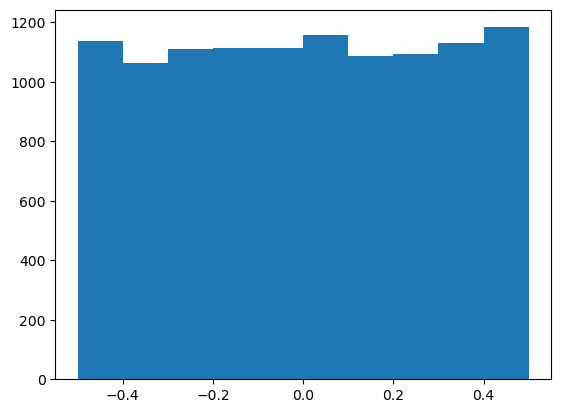

In [21]:
plt.hist(phases)
plt.show()

PINT compute the phases between -0.5 and 0.5. Normally, for pulsar analysis we work in the range [0,1], so we need to shift the negative phases.

In [22]:
phases = np.where(phases < 0.0 , phases + 1.0 , phases)

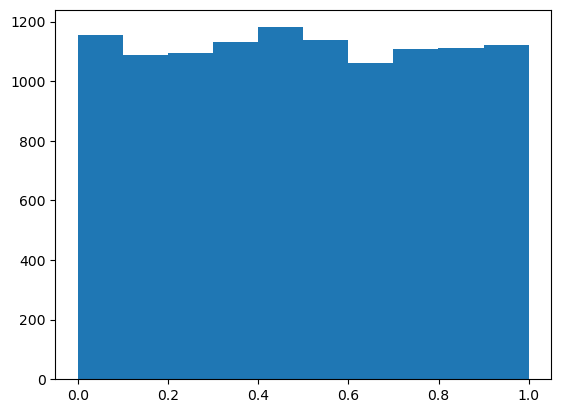

In [23]:
plt.hist(phases)
plt.show()

### 2.1.4 Removing tim file (optional)

Since the original times are located in the EventList we can remove the .tim file created to be used by PINT.

In [24]:
os.remove(str(os.getcwd()) + '/' + timname)

## 2.2 Second way: Using internal functions of PINT 

Actually, this should be the desirable way of proceeding but we need to understand better the functionalities of PINT. We do not need to create a .tim file, and we can create directly the TOAs object used in PINT by our own and perform the corrections step by step.

In [25]:
from pint import toa
from pint import models
from pint.observatory.topo_obs import TopoObs
from pint.models import get_model

In [26]:
### WHICH ONE IS THE CODE FOR MAGIC?
model = get_model(ephemeris_file)

In [27]:
%%time
include_bipm = True
include_gps = True

toa_list = list(toa.TOA(t, 4.5, obs='magic', ephem='DE421', include_bipm=str(include_bipm), 
                                include_gps=str(include_gps)) for t in times)
        
ts = toa.TOAs(toalist=toa_list)
ts.clock_corr_info={'include_bipm': str(include_bipm), 'include_gps': str(include_gps)}

ts.apply_clock_corrections(include_gps=include_gps,include_bipm=include_bipm)

ts.compute_TDBs(ephem='DE421')
ts.compute_posvels(ephem='DE421',planets=True)
        
phss = model.phase(ts,abs_phase=True)[1]
    
phases_2 = np.where(phss < 0.0 , phss + 1.0 , phss)

WARNING  (pint.observatory.topo_obs     ): No clock corrections found for observatory magic taken from file 
INFO     (pint.solar_system_ephemerides ): Set solar system ephemeris to de421 from download


CPU times: user 10.2 s, sys: 231 ms, total: 10.4 s
Wall time: 22.2 s


In [ ]:
ev_phase = EventList(table)
obs._events = ev_phase
phased_obs.append(obs)

## 3. Writing new EventList files

In [359]:
output_directory = './pulsar_data/'

In [360]:
#Create new EventList with the phases
table = observation.events.table

In [361]:
table

EVENT_ID,TIME,RA,DEC,ENERGY
,s,deg,deg,TeV
int64,float64,float32,float32,float32
2402,333778852.5099249,84.59457,22.03088,0.18194601
2408,333778852.5267153,84.21462,23.44914,0.08397394
2434,333778852.61315054,83.524704,22.725792,0.10596932
2445,333778852.6690142,83.76957,22.451006,0.19733498
2478,333778852.7627939,83.478516,23.484594,0.08522219
2481,333778852.7778549,83.71517,21.985115,1.0020943
...,...,...,...,...
356282,333780039.62997514,84.46133,21.69357,0.05068718


In [362]:
table['PHASE'] = phases.astype('float64')
table.sort('TIME')

In [363]:
table

EVENT_ID,TIME,RA,DEC,ENERGY,PHASE
,s,deg,deg,TeV,
int64,float64,float32,float32,float32,float64
2402,333778852.5099249,84.59457,22.03088,0.18194601,0.920936344960249
2408,333778852.5267153,84.21462,23.44914,0.08397394,0.4194144683982115
2434,333778852.61315054,83.524704,22.725792,0.10596932,0.9854328212944194
2445,333778852.6690142,83.76957,22.451006,0.19733498,0.6438742039002348
2478,333778852.7627939,83.478516,23.484594,0.08522219,0.42793890863078854
2481,333778852.7778549,83.71517,21.985115,1.0020943,0.8750558812037736
...,...,...,...,...,...
356282,333780039.62997514,84.46133,21.69357,0.05068718,0.2641134921735313


In [364]:
new_event_list = EventList(table)
observation._events = new_event_list

In [365]:
list_ids = list(map(int, f'{observation.obs_id:04d}'))  
filename = f'dl3_pulsar_{observation.obs_id:04d}.fits'
file_path = output_directory + filename

In [366]:
print('Writing outputfile in '+str(file_path))
observation.events.write(filename = file_path, gti = observation.gti, overwrite = True)

Writing outputfile in ./pulsar_data/dl3_pulsar_5029747.fits


## 4. Reading the new EventList files with the original DataStore information

-------------

## Making a phaseogram with basic statistics

In [493]:
off_phase_range = (0.6, 0.9)
on_phase_range = (0.35, 0.45)

In [494]:
pos_target = SkyCoord(ra=83.63 * u.deg, dec=22.01 * u.deg, frame="icrs")          
on_radius = 0.2*u.deg

on_region = SphericalCircleSkyRegion(pos_target, on_radius)

In [495]:
true_energy_axis = MapAxis.from_energy_bounds( 0.003, 10, 100, unit="TeV", name="energy_true")
reco_energy_axis = MapAxis.from_energy_bounds(0.01, 10, 30, unit="TeV", name="energy")


geom=RegionGeom.create(region = on_region, axes=[reco_energy_axis])
    
#Define empty Dataset
dataset_empty = SpectrumDataset.create(geom=geom,energy_axis_true=true_energy_axis)

#Define dataset maker
dataset_maker = SpectrumDatasetMaker(containment_correction=False, selection=["counts", "exposure", "edisp"], use_region_center=True)  

# Define background maker with the phase regions
phase_bkg_maker = PhaseBackgroundMaker(on_phase=on_phase_range, off_phase=off_phase_range)

dataset = dataset_maker.run(dataset_empty, observation)
dataset_on_off = phase_bkg_maker.run(dataset, observation)

In [496]:
stats_info = dataset_on_off.info_dict()

In [497]:
stats_info

{'name': 'lJglzk1R',
 'counts': 101,
 'excess': 12.666666666666657,
 'sqrt_ts': 1.1342448900013318,
 'background': 88.33333333333334,
 'npred': 91.5,
 'npred_background': 91.5,
 'npred_signal': nan,
 'exposure_min': <Quantity 2403.63682714 m2 s>,
 'exposure_max': <Quantity 1.63176031e+08 m2 s>,
 'livetime': <Quantity 1178.06627692 s>,
 'ontime': <Quantity 1188.11176187 s>,
 'counts_rate': <Quantity 0.08573372 1 / s>,
 'background_rate': <Quantity 0.07498163 1 / s>,
 'excess_rate': <Quantity 0.01075208 1 / s>,
 'n_bins': 30,
 'n_fit_bins': 30,
 'stat_type': 'wstat',
 'stat_sum': 20.629335006885206,
 'counts_off': 265,
 'acceptance': 3.0000000000000013,
 'acceptance_off': 9.000000000000004,
 'alpha': 0.33333333333333337}

## Draw the histogram

In [498]:
phases_on_region = observation.events.select_region(on_region).table['PHASE']

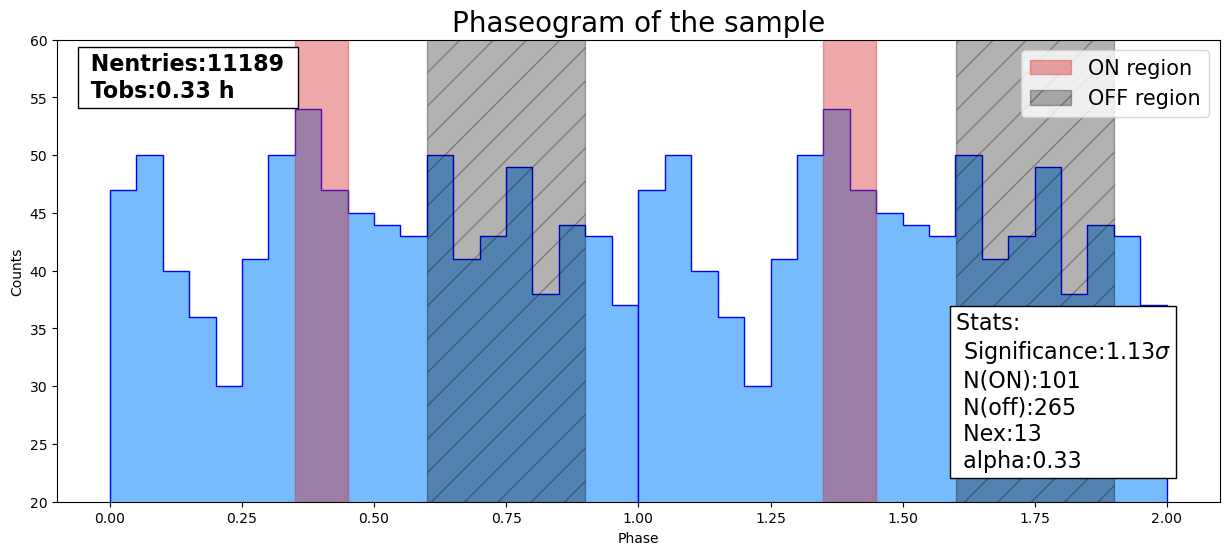

In [577]:
plt.figure(figsize=(15,6))
plt.title('Phaseogram of the sample',fontsize=20)
plt.hist(phases_on_region,bins=20, edgecolor='blue',facecolor='xkcd:sky blue',histtype='stepfilled')
plt.hist(phases_on_region+1,bins=20, edgecolor='blue',facecolor='xkcd:sky blue',histtype='stepfilled')
plt.fill_between(np.linspace(on_phase_range[0],on_phase_range[1]),0,650,color='C3',alpha=0.4)
plt.fill_between(np.linspace(on_phase_range[0],on_phase_range[1])+1,0,650,color='C3',alpha=0.4, label='ON region')
plt.fill_between(np.linspace(off_phase_range[0],off_phase_range[1]),0,650,color='k',alpha=0.3, hatch='/', label='OFF region')
plt.fill_between(np.linspace(off_phase_range[0],off_phase_range[1])+1,0,650,color='k',alpha=0.3, hatch='/')
plt.xlabel('Phase')
plt.ylabel('Counts')
plt.text(1.6,23,'Stats: \n Significance:{0:.2f}$\sigma$ \n N(ON):{1:.0f} \n N(off):{2:.0f} \n Nex:{3:.0f} \n alpha:{4:.2f}'.format(stats_info['sqrt_ts'], stats_info['counts'],stats_info['counts_off'],stats_info['excess'],stats_info['alpha']),
         fontsize=16,color='black',bbox=dict(facecolor='white', edgecolor='black'))
plt.text(-0.05,55,' Nentries:{0:.0f} \n Tobs:{1:.2f}'.format(len(table),stats_info['livetime'].to(u.Unit('h'))),
        fontsize=16,weight='bold',color='black',bbox=dict(facecolor='white', edgecolor='black'))
plt.ylim(20,60)
plt.legend(fontsize=15)
plt.show()